Evaluation of the [Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) from the New York City [Taxi and Limousine Commission](https://www.nyc.gov/site/tlc/about/about-tlc.page).

A primary concern is to minimize memory usage, which is to maximize the quantity of loadable data.

The three kinds of analyses performed are:
1. Tabular analysis of the full dataset.
1. Tabular analysis per day.
1. Graph analysis of zone-to-zone travel.

Open [this notebook](https://colab.research.google.com/github/greghogan/nyc-taxi/blob/main/nyc-taxi.ipynb) in [Google Colab](https://colab.research.google.com/).

Note: careful with the CPU credits if you are a freeloading customer.

To do:

1. Merge names with tabular and graph results.
1. Count trips by day.
1. Evaluation of green taxi and for-hire vehicle trips.

### Install modules

In [1]:
!pip install --quiet --disable-pip-version-check \
    matplotlib \
    networkx \
    pandas \
    pyarrow \
    psutil \
    pyshp \
    scipy

### Fetch trip data.

Use of the `--timestamping` option of `wget` prevents re-downloading of data.

In [2]:
years = [2022]
months = range(12) # zero-indexed

site = 'https://d37ci6vzurychx.cloudfront.net'

# Taxi Zone Lookup Table (CSV)
!wget --quiet --timestamping $f'{site}/misc/taxi+_zone_lookup.csv'

# Taxi Zone Shapefile (PARQUET)
!wget --quiet --timestamping $f'{site}/misc/taxi_zones.zip'
!unzip -n 'taxi_zones.zip'

for year in years:
    for month in months:
        # Yellow Taxi Trip Records (PARQUET)
        # ~50 MB/month
        yellow_tripdata = f'{site}/trip-data/yellow_tripdata_{year}-{month+1:02d}.parquet'
        !wget --quiet --timestamping $yellow_tripdata

        # Green Taxi Trip Records (PARQUET)
        # ~1 MB/month
        green_tripdata = f'{site}/trip-data/green_tripdata_{year}-{month+1:02d}.parquet'
        !wget --quiet --timestamping $green_tripdata

        # For-Hire Vehicle Trip Records (PARQUET)
        # ~10 MB/month
        fhv_tripdata = f'{site}/trip-data/fhv_tripdata_{year}-{month+1:02d}.parquet'
        !wget --quiet --timestamping $fhv_tripdata

        # High Volume For-Hire Vehicle Trip Records (PARQUET)
        # ~500 MB/month
        fhvhv_tripdata = f'{site}/trip-data/fhvhv_tripdata_{year}-{month+1:02d}.parquet'
        #!wget --quiet --timestamping $fhvhv_tripdata

Archive:  taxi_zones.zip


### Analyze memory usage and Python garbage collection

In [5]:
import gc
import psutil
import time

# RSS is the Resident Set Size, the amount of memory allocated to a process and in RAM. It does not include memory swapped to disk.

garbage_collection_timeout_seconds = 3

class MemoryUsage():
    # Process memory (RAM) use is measured at three points: before and after the enclosed with statement
    # and finally after performing a garbage collection. Ideally we want to minimize peak memory but we
    # also look to free as much memory as quickly as possible.

    @staticmethod
    def _collect():
        # there are additional flags that could be used https://docs.python.org/3/library/gc.html
        gc.set_debug(gc.DEBUG_STATS)
        gc.collect()
        # it seems appropriate to unset the debug flags although this may have no affect in a notebook
        gc.set_debug(0)
        # garbage collection seems to be asynchronous; it is possible to register a callback but
        # instead simply wait for system to hopefully finish and settle
        time.sleep(garbage_collection_timeout_seconds)

    def __enter__(self):
        print('Entry garbage collection:')
        self._collect()
        self.enter_rss = psutil.Process().memory_info().rss

    def __exit__(self, exc_type, exc_val, exc_tb):
        print('Exit garbage collection:')
        self.exit_rss = psutil.Process().memory_info().rss
        self._collect()
        self.post_gc_rss = psutil.Process().memory_info().rss

        increase = self.exit_rss - self.enter_rss
        collected = self.post_gc_rss - self.exit_rss
        print(f'RAM used on entry: {self.enter_rss:,} bytes')
        print(f'RAM used on exit: {self.exit_rss:,} bytes')
        print(f'RAM used after garbage collect: {self.post_gc_rss:,} bytes')
        print(f'RAM increased by {increase:,} bytes and garbage collect recovered {collected:,} bytes')

In [2]:
import pandas as pd

### Memory usage for one month of yellow trip data

In [5]:
with MemoryUsage():
    data = pd.concat(pd.read_parquet(f'yellow_tripdata_2022-{month+1:02d}.parquet') for month in range(1))
    data.info()

Entry garbage collection:


gc: collecting generation 2...
gc: objects in each generation: 634 1652 119464
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0354s elapsed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

gc: collecting generation 2...
gc: objects in each generation: 152 2166 121063
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0457s elapsed


RAM used on entry: 119,504,896 bytes
RAM used on exit: 666,689,536 bytes
RAM used after garbage collect: 666,689,536 bytes
RAM increased by 547,184,640 bytes and garbage collect recovered 0 bytes


### Memory usage for twelve months of yellow trip data

In [8]:
with MemoryUsage():
    data = pd.concat(pd.read_parquet(f'yellow_tripdata_2022-{month+1:02d}.parquet') for month in range(12))
    data.info(memory_usage='deep')

Entry garbage collection:


gc: collecting generation 2...
gc: objects in each generation: 275 106 123088
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0308s elapsed


<class 'pandas.core.frame.DataFrame'>
Index: 39656098 entries, 0 to 3399548
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            flo

gc: collecting generation 2...
gc: objects in each generation: 286 42 123073
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.1199s elapsed


RAM used on entry: 667,119,616 bytes
RAM used on exit: 1,826,156,544 bytes
RAM used after garbage collect: 1,894,842,368 bytes
RAM increased by 1,159,036,928 bytes and garbage collect recovered 68,685,824 bytes


### Parquet Fields for Yellow Taxi trip data

|  #  | Column                | Dtype
| --- |-----------------------| -----
|  0  | VendorID              | int64
|  1  | tpep_pickup_datetime  | datetime64[ns]
|  2  | tpep_dropoff_datetime | datetime64[ns]
|  3  | passenger_count       | float64
|  4  | trip_distance         | float64
|  5  | RatecodeID            | float64
|  6  | store_and_fwd_flag    | object
|  7  | PULocationID          | int64
|  8  | DOLocationID          | int64
|  9  | payment_type          | int64
|  10 | fare_amount           | float64
|  11 | extra                 | float64
|  12 | mta_tax               | float64
|  13 | tip_amount            | float64
|  14 | tolls_amount          | float64
|  15 | improvement_surcharge | float64
|  16 | total_amount          | float64
|  17 | congestion_surcharge  | float64
|  18 | airport_fee           | float64

Each of the 18 fields requires 8 bytes, which for ~40 million records yields the ~6 GB of memory usage reported in the previous block. Instead we will load only a subset of columns while converting to integer values.

A 64-bit integer stores far larger values than the population of earth, or the total global currency. The Parquet file format masks this inefficiency on disk by ultimately compressing the wasted zeroes, but when loaded into memory a far more precious resource is wasted.

Ideally Pandas would provide a method to automatically and efficiently compact columns based on float-to-int (passenger count) and affine (monetary) conversion after analyzing the minimum, maximum, and range of values. Additional types including variable-length integers, and compressed floating point types would further reduce memory usage.

![data types](data_types.png)

In [6]:
columns = {
    'VendorID': 'uint8',
    'passenger_count': 'uint8',
    'RatecodeID': 'uint8',
    'trip_distance': 'uint16',
    'PULocationID': 'uint16',
    'DOLocationID': 'uint16',
    'payment_type': 'uint8',
    'total_amount': 'int16'}

columns_dollars_to_cents = ['trip_distance', 'total_amount']

# affine value with multiplier
def round_product(multiplier = None):
    return lambda x: round(x * multiplier)

def load_data(year):
    data = []

    for month in range(12):
        df = pd.read_parquet(f'yellow_tripdata_{year}-{month+1:02d}.parquet', columns=columns.keys())

        # not-a-number floating point values have no integer representation and cannot be converted
        df.dropna(inplace=True)

        # this column-by-column conversion looks to be efficient as a DataFrame is a collection of Series
        for column in columns_dollars_to_cents:
            df[column] = df[column].apply(round_product(100))

        # after converting the floating point values the type conversions can be processed
        data.append(df.astype(columns, copy=False))

    return pd.concat((data), ignore_index=True)

In [7]:
with MemoryUsage():
    taxi_data = load_data('2022')

taxi_data.info(memory_usage='deep')
taxi_data.head()

Entry garbage collection:


gc: collecting generation 2...
gc: objects in each generation: 278 357 147548
gc: objects in permanent generation: 0
gc: done, 476 unreachable, 0 uncollectable, 0.0516s elapsed


Exit garbage collection:


gc: collecting generation 2...
gc: objects in each generation: 44 1825 146416
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0587s elapsed


RAM used on entry: 126,476,288 bytes
RAM used on exit: 1,057,419,264 bytes
RAM used after garbage collect: 1,057,546,240 bytes
RAM increased by 930,942,976 bytes and garbage collect recovered 126,976 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38287795 entries, 0 to 38287794
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   VendorID         uint8 
 1   passenger_count  uint8 
 2   RatecodeID       uint8 
 3   trip_distance    uint16
 4   PULocationID     uint16
 5   DOLocationID     uint16
 6   payment_type     uint8 
 7   total_amount     int16 
dtypes: int16(1), uint16(3), uint8(4)
memory usage: 438.2 MB


,VendorID,passenger_count,RatecodeID,trip_distance,PULocationID,DOLocationID,payment_type,total_amount
0,1,2,1,380,142,236,1,2195
1,1,1,1,210,236,42,1,1330
2,2,1,1,97,166,166,1,1056
3,2,1,1,109,114,68,2,1180
4,2,1,1,430,68,163,1,3030


In [12]:
taxi_zone = pd.read_csv('taxi+_zone_lookup.csv')
taxi_zone.info(memory_usage='deep')
taxi_zone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 54.8 KB


,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


### Histogram of passenger counts

average number of passengers: 1.4
average total fare: $21.35


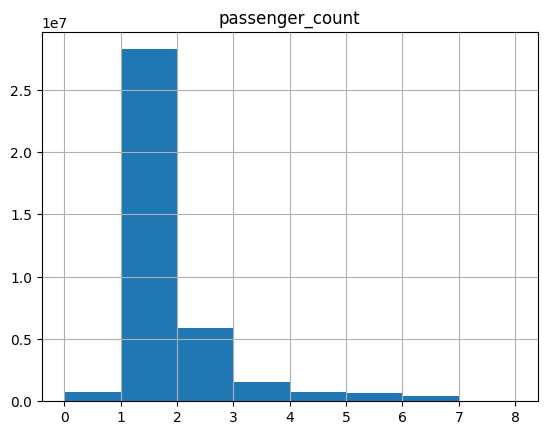

In [11]:
taxi_data.hist(column='passenger_count', bins=range(taxi_data['passenger_count'].max()))

average_passenger_count = round(taxi_data['passenger_count'].mean(), 2)
print(f'average number of passengers: {average_passenger_count}')

average_total_amount = round(taxi_data['total_amount'].mean()/100, 2)
print(f'average total fare: ${average_total_amount}')

In [14]:
import networkx as nx

In [15]:
grouped_data = taxi_data.groupby(['PULocationID', 'DOLocationID'], as_index=False).size()
taxi_graph = nx.from_pandas_edgelist(grouped_data, 'PULocationID', 'DOLocationID', edge_attr='size', create_using=nx.DiGraph)

# some algorithms prohibit self-loops
taxi_graph.remove_edges_from(nx.selfloop_edges(taxi_graph))

### PageRank

In [16]:
pd.Series(nx.pagerank(taxi_graph, weight='size'))

1      0.004193
6      0.002170
10     0.004419
13     0.003910
14     0.005146
         ...   
206    0.002310
105    0.000827
59     0.001969
110    0.000591
199    0.000572
Length: 263, dtype: float64

### Graph diameter

In [17]:
nx.diameter(taxi_graph.to_undirected())

2

### Clustering Coefficient

In [20]:
pd.Series(nx.clustering(taxi_graph)).sort_values(ascending=False)

199    1.000000
105    0.992236
111    0.974896
8      0.964460
34     0.950161
         ...   
161    0.672402
140    0.661863
132    0.655192
264    0.648717
110    0.000000
Length: 263, dtype: float64

### Betweenness Centrality

In [21]:
pd.Series(nx.betweenness_centrality(taxi_graph)).sort_values(ascending=False)

132    9.992073e-03
264    7.560346e-03
74     5.988794e-03
140    5.843098e-03
75     5.478972e-03
           ...     
99     6.647822e-06
111    2.570176e-06
105    9.880900e-08
110    0.000000e+00
199    0.000000e+00
Length: 263, dtype: float64

### Imbalance of pickup and dropoffs

In [11]:
pu = taxi_data['PULocationID'].value_counts()
do = taxi_data['DOLocationID'].value_counts()

total = (pu + do)
imbalance = (do - pu)
imbalance_ratio = (imbalance / total).abs()

trip_counts = pd.DataFrame({'PU': pu, 'DO': do, 'total': total, 'imbalance': imbalance, 'imbalance_ratio': imbalance_ratio})
trip_counts.sort_values(by='imbalance_ratio', ascending=False)

,PU,DO,total,imbalance,imbalance_ratio
27,22.0,615.0,637.0,593.0,0.930926
257,618.0,15960.0,16578.0,15342.0,0.925443
198,955.0,20687.0,21642.0,19732.0,0.911746
58,52.0,1067.0,1119.0,1015.0,0.907060
245,24.0,438.0,462.0,414.0,0.896104
...,...,...,...,...,...
140,773846.0,784054.0,1557900.0,10208.0,0.006552
229,810401.0,818566.0,1628967.0,8165.0,0.005012
207,3550.0,3521.0,7071.0,-29.0,0.004101
110,NaN,3.0,NaN,NaN,NaN
